In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  


2.0.1+cu117
True


In [2]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
])


dataset = datasets.ImageFolder(root='Data/train', transform=transform)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Biến để lưu tổng và tổng bình phương của các pixel
mean = 0.0
std = 0.0
n_samples = 0

for images, _ in dataloader:
    # Chuyển đổi batch ảnh sang kích thước [batch_size, height, width]
    images = images.view(images.size(0), -1)
    mean += images.mean(1).sum(0)
    std += images.std(1).sum(0)
    n_samples += images.size(0)


mean /= n_samples
std /= n_samples

print(f'Mean: {mean.item()}, Std: {std.item()}')


Mean: 0.49243637919425964, Std: 0.21605263650417328


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.4924529492855072], std=[0.21606244146823883])  
])


full_train_data = datasets.ImageFolder(root='Data/train', transform=transform)


train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


test_data = datasets.ImageFolder(root='Data/test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


print(full_train_data.classes)  # ['COVID19', 'NORMAL', 'PNEUMONIA']


['COVID19', 'NORMAL', 'PNEUMONIA']


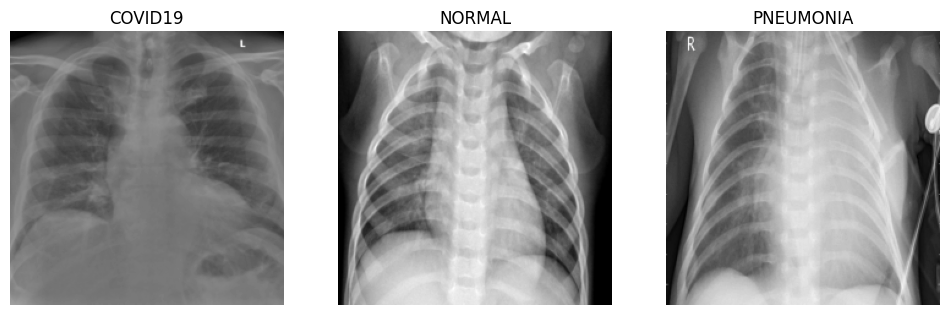

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img.squeeze(0).numpy()  
    img = np.transpose(img, (1, 2, 0)) 
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')


dataloader = DataLoader(full_train_data, batch_size=1, shuffle=True)


sample_images = {cls: None for cls in full_train_data.classes}
for img, label in dataloader:
    cls = full_train_data.classes[label.item()]
    if sample_images[cls] is None:
        sample_images[cls] = img
        if all(img is not None for img in sample_images.values()):
            break


plt.figure(figsize=(12, 4))
for i, (cls, img) in enumerate(sample_images.items()):
    plt.subplot(1, len(sample_images), i + 1)
    imshow(img, cls)

plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [6]:
for name, module in model.named_children():
    print(f"Layer: {name} - {module}")

outputs = {}

def hook_fn(module, input, output):
    layer_name = module.__class__.__name__
    outputs[layer_name] = output


hooks = []
for name, module in model.named_children():
    hooks.append(module.register_forward_hook(hook_fn))


x = torch.randn(1, 1, 224, 224).to(device)  # Batch size = 1, 1 channel, image size 224x224


with torch.no_grad():
    model(x)

# In output của từng lớp
for layer, output in outputs.items():
    print(f"{layer} output shape: {output.shape}")


for hook in hooks:
    hook.remove()


Layer: conv1 - Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer: bn1 - BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer: conv2 - Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer: bn2 - BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer: conv3 - Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer: bn3 - BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer: conv4 - Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer: bn4 - BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer: fc1 - Linear(in_features=50176, out_features=512, bias=True)
Layer: dropout - Dropout(p=0.5, inplace=False)
Layer: fc2 - Linear(in_features=512, out_features=256, bias=True)
Layer: fc3 - Linear(in_features=256, out_features=3, bias=True)
Conv2d output shape: torch.Size([1, 256, 28, 28])
Batch

In [7]:
import torch.optim as optim
import torch.nn as nn


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Reset gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

      
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

      
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model)
                break

    print('Finished Training')
    return model


model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)


Epoch [1/30], Loss: 0.8059, Val Loss: 0.2660, Val Accuracy: 90.28%
Epoch [2/30], Loss: 0.2325, Val Loss: 0.1854, Val Accuracy: 94.27%
Epoch [3/30], Loss: 0.2083, Val Loss: 0.1562, Val Accuracy: 94.46%
Epoch [4/30], Loss: 0.1900, Val Loss: 0.1545, Val Accuracy: 94.56%
Epoch [5/30], Loss: 0.1937, Val Loss: 0.1669, Val Accuracy: 95.04%
Epoch [6/30], Loss: 0.1773, Val Loss: 0.1710, Val Accuracy: 94.27%
Epoch [7/30], Loss: 0.1445, Val Loss: 0.1022, Val Accuracy: 96.99%
Epoch [8/30], Loss: 0.1567, Val Loss: 0.1288, Val Accuracy: 96.21%
Epoch [9/30], Loss: 0.1382, Val Loss: 0.1005, Val Accuracy: 96.99%
Epoch [10/30], Loss: 0.1454, Val Loss: 0.1287, Val Accuracy: 95.63%
Epoch [11/30], Loss: 0.1339, Val Loss: 0.1093, Val Accuracy: 96.21%
Epoch [12/30], Loss: 0.1203, Val Loss: 0.1494, Val Accuracy: 94.95%
Epoch [13/30], Loss: 0.1127, Val Loss: 0.1043, Val Accuracy: 96.70%
Epoch [14/30], Loss: 0.1064, Val Loss: 0.1255, Val Accuracy: 96.02%
Early stopping triggered at epoch 14
Finished Training


In [8]:
def evaluate_model_metrics(model, loader, classes):
    model.eval()
    num_classes = len(classes)
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(num_classes):
                true_positives[i] += ((predicted == i) & (labels == i)).sum().item()
                false_positives[i] += ((predicted == i) & (labels != i)).sum().item()
                false_negatives[i] += ((predicted != i) & (labels == i)).sum().item()

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    precision = [0] * num_classes
    recall = [0] * num_classes
    f1_score = [0] * num_classes

    for i in range(num_classes):
        if true_positives[i] + false_positives[i] > 0:
            precision[i] = true_positives[i] / (true_positives[i] + false_positives[i])
        if true_positives[i] + false_negatives[i] > 0:
            recall[i] = true_positives[i] / (true_positives[i] + false_negatives[i])
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    accuracy = 100 * total_correct / total_samples

    for i in range(num_classes):
        print(f'Class {classes[i]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1-Score = {f1_score[i]:.4f}')
    print(f'Overall Accuracy: {accuracy:.2f}%')


classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

print('Evaluate on Test Dataset: ')
evaluate_model_metrics(model, test_loader, classes)


Evaluate on Test Dataset: 
Class COVID19: Precision = 0.9829, Recall = 0.9914, F1-Score = 0.9871
Class NORMAL: Precision = 0.8879, Recall = 0.9495, F1-Score = 0.9177
Class PNEUMONIA: Precision = 0.9808, Recall = 0.9544, F1-Score = 0.9674
Overall Accuracy: 95.65%


In [9]:
# Lưu mô hình
torch.save(model.state_dict(), 'covid_classifier.pth')

# Tải mô hình
model = SimpleCNN()
model.load_state_dict(torch.load('covid_classifier.pth'))
model = model.to(device)


## Confusion Matrix

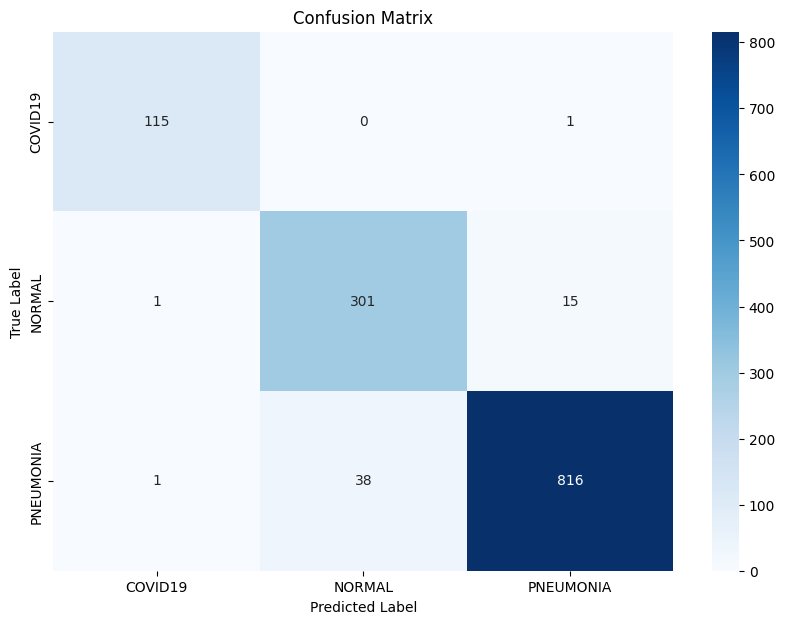

In [10]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

   
    cm = confusion_matrix(all_labels, all_preds)
    
  
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


classes = ['COVID19', 'NORMAL', 'PNEUMONIA']
plot_confusion_matrix(model, test_loader, classes)


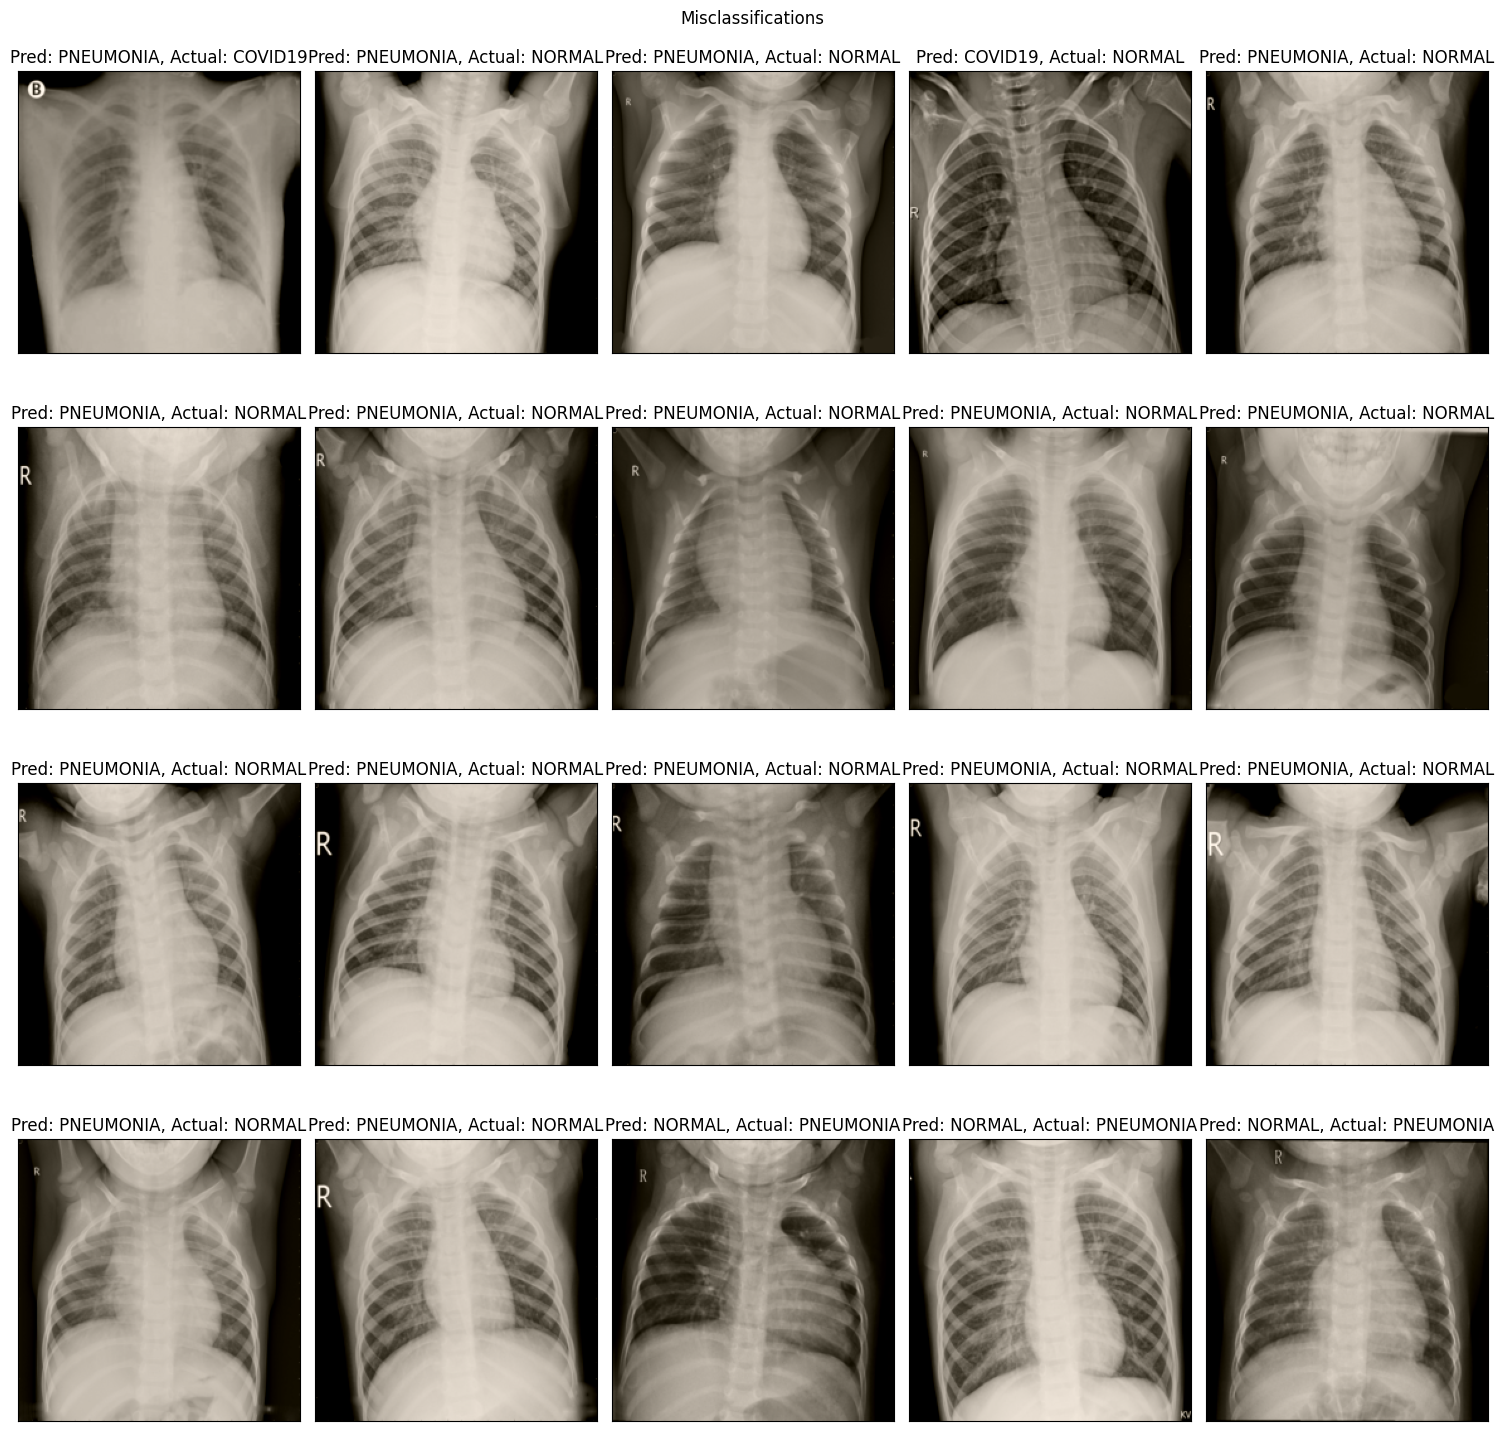

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_misclassified_images(model, loader, classes, num_images_to_show=20):
    model.eval()
    misclassified_images = []
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            
            all_images.extend(images.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

           
            for i in range(len(labels)):
                if preds[i].item() != labels[i].item():  
                    misclassified_images.append(len(all_labels) - len(labels) + i)

    
    plt.figure(figsize=(15, 15))
    plt.suptitle('Misclassifications')

    for plot_index, bad_index in enumerate(misclassified_images[:num_images_to_show]):
        ax = plt.subplot(4, 5, plot_index + 1)  
        image = all_images[bad_index].transpose(1, 2, 0)  
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  
        image = np.clip(image, 0, 1) 
        ax.imshow(image)
        ax.set_xticks([]); ax.set_yticks([])  

       
        ax.set_title(f'Pred: {classes[all_preds[bad_index]]}, Actual: {classes[all_labels[bad_index]]}')

    plt.tight_layout()
    plt.show()


classes = full_train_data.classes  # ['COVID19', 'NORMAL', 'PNEUMONIA']
plot_misclassified_images(model, test_loader, classes, num_images_to_show=20)


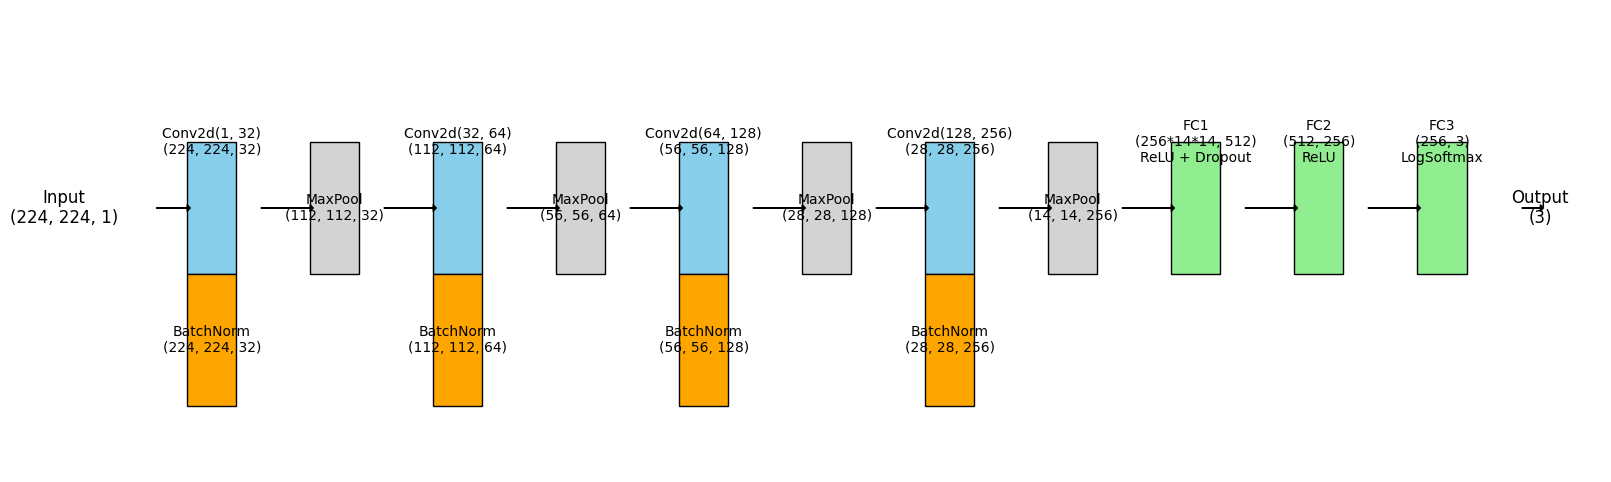

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_cnn():
    fig, ax = plt.subplots(figsize=(20, 6))

    # Input layer
    ax.text(0, 0, 'Input\n(224, 224, 1)', ha='center', va='center', fontsize=12)

    # Conv Layer 1
    ax.add_patch(Rectangle((2, -0.5), 0.8, 1, edgecolor='black', facecolor='skyblue'))
    ax.text(2.4, 0.5, 'Conv2d(1, 32)\n(224, 224, 32)', ha='center', va='center', fontsize=10)
    ax.add_patch(Rectangle((2, -1.5), 0.8, 1, edgecolor='black', facecolor='orange'))
    ax.text(2.4, -1, 'BatchNorm\n(224, 224, 32)', ha='center', va='center', fontsize=10)
    ax.arrow(1.5, 0, 0.5, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Max Pooling Layer 1
    ax.add_patch(Rectangle((4, -0.5), 0.8, 1, edgecolor='black', facecolor='lightgray'))
    ax.text(4.4, 0, 'MaxPool\n(112, 112, 32)', ha='center', va='center', fontsize=10)
    ax.arrow(3.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Conv Layer 2
    ax.add_patch(Rectangle((6, -0.5), 0.8, 1, edgecolor='black', facecolor='skyblue'))
    ax.text(6.4, 0.5, 'Conv2d(32, 64)\n(112, 112, 64)', ha='center', va='center', fontsize=10)
    ax.add_patch(Rectangle((6, -1.5), 0.8, 1, edgecolor='black', facecolor='orange'))
    ax.text(6.4, -1, 'BatchNorm\n(112, 112, 64)', ha='center', va='center', fontsize=10)
    ax.arrow(5.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Max Pooling Layer 2
    ax.add_patch(Rectangle((8, -0.5), 0.8, 1, edgecolor='black', facecolor='lightgray'))
    ax.text(8.4, 0, 'MaxPool\n(56, 56, 64)', ha='center', va='center', fontsize=10)
    ax.arrow(7.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Conv Layer 3
    ax.add_patch(Rectangle((10, -0.5), 0.8, 1, edgecolor='black', facecolor='skyblue'))
    ax.text(10.4, 0.5, 'Conv2d(64, 128)\n(56, 56, 128)', ha='center', va='center', fontsize=10)
    ax.add_patch(Rectangle((10, -1.5), 0.8, 1, edgecolor='black', facecolor='orange'))
    ax.text(10.4, -1, 'BatchNorm\n(56, 56, 128)', ha='center', va='center', fontsize=10)
    ax.arrow(9.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Max Pooling Layer 3
    ax.add_patch(Rectangle((12, -0.5), 0.8, 1, edgecolor='black', facecolor='lightgray'))
    ax.text(12.4, 0, 'MaxPool\n(28, 28, 128)', ha='center', va='center', fontsize=10)
    ax.arrow(11.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Conv Layer 4
    ax.add_patch(Rectangle((14, -0.5), 0.8, 1, edgecolor='black', facecolor='skyblue'))
    ax.text(14.4, 0.5, 'Conv2d(128, 256)\n(28, 28, 256)', ha='center', va='center', fontsize=10)
    ax.add_patch(Rectangle((14, -1.5), 0.8, 1, edgecolor='black', facecolor='orange'))
    ax.text(14.4, -1, 'BatchNorm\n(28, 28, 256)', ha='center', va='center', fontsize=10)
    ax.arrow(13.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Max Pooling Layer 4
    ax.add_patch(Rectangle((16, -0.5), 0.8, 1, edgecolor='black', facecolor='lightgray'))
    ax.text(16.4, 0, 'MaxPool\n(14, 14, 256)', ha='center', va='center', fontsize=10)
    ax.arrow(15.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Fully Connected Layer 1
    ax.add_patch(Rectangle((18, -0.5), 0.8, 1, edgecolor='black', facecolor='lightgreen'))
    ax.text(18.4, 0.5, 'FC1\n(256*14*14, 512)\nReLU + Dropout', ha='center', va='center', fontsize=10)
    ax.arrow(17.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Fully Connected Layer 2
    ax.add_patch(Rectangle((20, -0.5), 0.8, 1, edgecolor='black', facecolor='lightgreen'))
    ax.text(20.4, 0.5, 'FC2\n(512, 256)\nReLU', ha='center', va='center', fontsize=10)
    ax.arrow(19.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Fully Connected Layer 3
    ax.add_patch(Rectangle((22, -0.5), 0.8, 1, edgecolor='black', facecolor='lightgreen'))
    ax.text(22.4, 0.5, 'FC3\n(256, 3)\nLogSoftmax', ha='center', va='center', fontsize=10)
    ax.arrow(21.2, 0, 0.8, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    # Output Layer
    ax.text(24, 0, 'Output\n(3)', ha='center', va='center', fontsize=12)
    ax.arrow(23.7, 0, 0.3, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

    ax.set_xlim(-0.2, 25)
    ax.set_ylim(-2, 1.5)
    ax.axis('off')
    plt.show()

draw_cnn()
